In [34]:
from scipy.fftpack import fft,ifft, rfft, irfft
import numpy as np
import cmath
import matplotlib.pyplot as plt
from scipy.io import wavfile

In [35]:
%matplotlib inline

ALL OF THE CONDITIONS MUST BE TRUE

In [36]:
NumberofWindows = 300 #M
WindowSize= 400 #N
Overlap = 0.75 # actually its the nonoverlaping percentage
(WindowSize*Overlap - int(WindowSize*Overlap))==0 #require that size * overlap is integer

True

In [37]:
ClipLen = WindowSize * Overlap* (NumberofWindows) + WindowSize*(1-Overlap) 
(int(ClipLen) -ClipLen)==0 #CLipLen is also must be an int

True

In [38]:
rate, data = wavfile.read('Norah Jones - The Story.wav')

D:\ANACONDA33\lib\site-packages\scipy\io\wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


In [39]:
len(data)

481105

In [40]:
ClipLen<=len(data)

True

In [41]:
ClipLen =int(ClipLen) 
noisedata = np.random.normal(0,5142000,len(data))
noise = np.asarray(noisedata, np.int16)
wavfile.write('noise.wav', rate, noise)

In [42]:
snd = data[0:ClipLen+1]
snd1 = noise[0:ClipLen+1] 
SoundWithNoise = np.asarray(0.9* snd+ 0.1*snd1 , np.int16)
wavfile.write('noiseandsignal_01.wav', rate, SoundWithNoise) # creating the noise wav file
#SoundWithNoise

In [43]:
snd1.shape

(90101,)

In [44]:
SoundClip = SoundWithNoise[0:ClipLen+1]
#len(SoundClip)

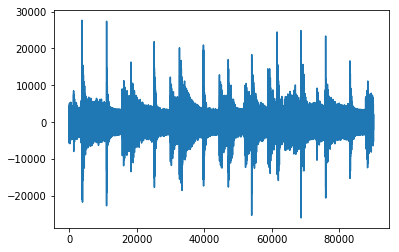

In [45]:
plt.plot(SoundClip)

D:\ANACONDA33\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in sqrt
  


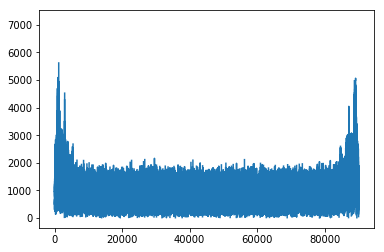

In [46]:
spectrum = fft(SoundClip)
plt.plot(np.sqrt(np.imag(spectrum)*2 + np.real(spectrum)*2))

In [47]:
def WF(N): #N is the window size
    n = np.arange(N)
    a =25/46 -(1-25/46)*np.cos((2*np.pi*n)/(N-1))
    return a

In [48]:
ImPart = np.zeros((NumberofWindows, WindowSize)) #(M,N)
RePart = np.zeros((NumberofWindows, WindowSize)) #(M,N)

In [49]:
def Windowing():
    MaxValue = 0
    i = 0
    position = 0
   
    #while i * WindowSize <= ClipLen:
    while (position + WindowSize <= ClipLen):
        #print('i is :', i)
        #print('i * WindowSize is : ', i * WindowSize)
        #print('WF is : ', WF(WindowSize)) 
        
        window = WF(WindowSize)*SoundClip [position: position+WindowSize]
        #print('Window is : ', window)
        
        FourierWindow = fft(window)
        #print('FourierWindow is : ', FourierWindow)
        
        RePart[i,:] = np.real(FourierWindow[:])
        #print('RePart is : ', RePart[i,:])      
        
        ImPart[i,:]= np.imag(FourierWindow[:])
        #print('ImPart is : ', ImPart[i,:])     
        
        Max = np.max(np.abs(FourierWindow))
        #print('Max is : ',Max)            
        
        if(Max >MaxValue):
            MaxValue=Max
        i=i+1
        position = int(position+WindowSize * Overlap)
        
        #print('Positon is : ', position)
        #print('End of the LOOP ')
        #print(' ')
      
    return [RePart,ImPart,MaxValue]

In [50]:
#Main, 
[RePart,ImPart,MaxValue]= Windowing()

In [51]:
#8
STFT = np.sqrt(RePart**2+ ImPart**2) #???????????????????????????
#STFT #is a matrix with size (NumberofWindows, Windowsize)

In [52]:
#9
Phase = np.zeros((NumberofWindows, WindowSize)) #(M,N)
for i in range(NumberofWindows):
    for j in range(WindowSize):
        #print(RePart[i,j], ImPart[i,j])
        Phase[i,j]=cmath.phase(complex(RePart[i,j], ImPart[i,j]))
#Phase

Now the PDE part:
Finite Difference method

$$u_{t} = q_{x} \hspace{0.1cm} C(u) \hspace{0.1cm} u_{xx}$$
$$C(u)= \frac{1}{1+e^{-k(u-\eta)}}$$

In [53]:
T = 10 #number of iterations ,   t
M = NumberofWindows#y ,    j
N = WindowSize #x ,      i


# we will set dx = 1,dy = 1,dt = 1 and we wont use them in the FDM as they wont matter

In [54]:
eta = 0.05

#of the noise in the frequency domain =power spectrum= magnitude of fourier transform )
# step of the sigmoid
q= 0.5 # ? scaling factor for the defusive term
k = 10**5 #the steepness of the curve
def C(u):
    return 1/(1+ np.exp(-k*(u-eta)))

In [55]:
def PDESignalRemoval(InitialCondition):
    #initialization 
    u = np.zeros((T+1, M+1, N+1)) #ALL BOUNDARIES ARE 0,  no need for separate initialization
    u[0,1:,1:] = InitialCondition  #as the MagnitudeSTFT has size(M,N) and u[0,:,:] has (N+1 ,M+1)
    
    for t in range(T): 
        for j in range(1,M+1): #run in all windows, y 
            for i in range(1,N): #run inside the window 
                u[t+1,j,i] = u[t,j,i]+ q * C(u[t,j,i]) * (u[t,j,i-1]- 2*(u[t,j,i])+u[t,j,i+1]) 
                
    return u[T,1:,1:]  

In [56]:
#10
STFT2 = PDESignalRemoval(STFT/MaxValue)

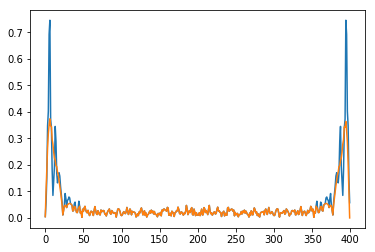

In [57]:
ii = 12
plt.plot((STFT/MaxValue)[ii])
plt.plot(STFT2[ii])

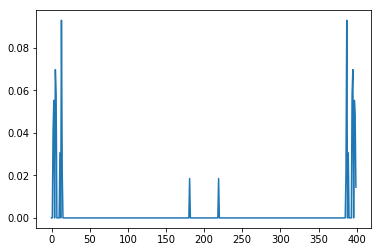

In [58]:
ii = 20
plt.plot(((STFT/MaxValue)[ii] - STFT2[ii]))

In [59]:
#11
STFT_New= STFT - STFT2*MaxValue

In [60]:
#12,13
RePart= STFT_New* np.cos(Phase)
ImPart= STFT_New* np.sin(Phase)

In [61]:
def UnWindow():
    position = 0
    NewSoundClip = np.zeros(ClipLen+1)
    for i in range(NumberofWindows):         
        TempClip = np.real(ifft((RePart[i])+ 1j*(ImPart[i])))
        Ave = NewSoundClip[position: position+int(WindowSize*Overlap)] +TempClip[0: int(WindowSize*Overlap)]
        NonOverlapSec = TempClip[int(WindowSize*Overlap):] 
        NewSoundClip[position: position + WindowSize] =np.concatenate((Ave, NonOverlapSec),axis=0)          
        position= position + int(WindowSize*Overlap)   
    return NewSoundClip

In [62]:
#14
New_SoundClip = UnWindow()

In [63]:
New_SoundClip = np.asarray(New_SoundClip, np.int16)

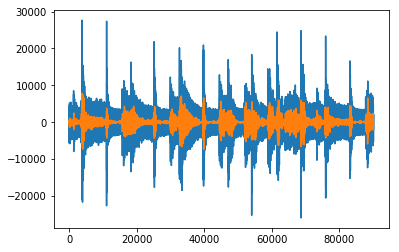

In [64]:
plt.plot(SoundClip)
plt.plot(New_SoundClip)


In [65]:
wavfile.write("NEW_Norah Jones - The Story.wav", rate, New_SoundClip)# do with te soundclip data